# Topic Modeling for news feeds
This notebook is based on the tutorial at https://ahmedbesbes.com/how-to-mine-newsfeed-data-and-extract-interactive-insights-in-python.html

# 1) Importing key modules

In [1]:
# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# For data processing and modeling
import nltk
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

from string import punctuation
from collections import Counter
import re
from tqdm import tqdm_notebook

In [4]:
# For LDA visuals
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook() 

C:\Program Files\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:420: DeprecationWarning: invalid escape sequence \s
  """


# 2) Loading dataset

In [5]:
data = pd.read_csv('news.csv')

In [6]:
data.head()

,author,description,publishedAt,source,title,url,urlToImage,category,scraping_date
0,http://www.abc.net.au/news/lisa-millar/166890,In the month following Donald Trump's inaugura...,2017-02-26T08:08:20Z,abc-news-au,Has Russia changed its tone towards Donald Trump?,http://www.abc.net.au/news/2017-02-26/donald-t...,http://www.abc.net.au/news/image/8300726-1x1-7...,general,2017-02-26 13:08:22.317772
1,http://www.abc.net.au/news/emily-sakzewski/768...,A fasting diet could reverse diabetes and repa...,2017-02-26T04:39:24Z,abc-news-au,Fasting diet 'could reverse diabetes and regen...,http://www.abc.net.au/news/2017-02-26/fasting-...,http://www.abc.net.au/news/image/8304732-1x1-7...,general,2017-02-26 13:08:22.317772
2,http://www.abc.net.au/news/jackson-vernon/7531870,Researchers discover what could be one of the ...,2017-02-26T02:02:28Z,abc-news-au,Mine pollution turning Blue Mountains river in...,http://www.abc.net.au/news/2017-02-26/blue-mou...,http://www.abc.net.au/news/image/8304524-1x1-7...,general,2017-02-26 13:08:22.317772
3,http://www.abc.net.au/news/sophie-mcneill/4516794,Yemen is now classified as the world's worst h...,2017-02-26T09:56:12Z,abc-news-au,Australia ignores unfolding humanitarian catas...,http://www.abc.net.au/news/2017-02-26/humanita...,http://www.abc.net.au/news/image/7903812-1x1-7...,general,2017-02-26 13:08:22.317772
4,http://www.abc.net.au/news/dan-conifer/5189074...,Malcolm Turnbull and Joko Widodo hold talks in...,2017-02-26T03:43:04Z,abc-news-au,Australia and Indonesia agree to fully restore...,http://www.abc.net.au/news/2017-02-26/indonesi...,http://www.abc.net.au/news/image/8304516-1x1-7...,general,2017-02-26 13:08:22.317772


In [7]:
data.shape

(50126, 9)

 we will be mainly focusing on the description column for out topic modeling purpose

In [8]:
data.description[0]

"In the month following Donald Trump's inauguration it's clear that Russians are no longer jumping down the aisles."

In [9]:
data.description[50125]

'Police say 15 people were shot and one person was killed when gunfire erupted at a Cincinnati nightclub.'

In [10]:
chars = list(set(data.description)) 
data_size, vocab_size = len(data.description), len(chars)
print ("data has chars", data_size)
print ("data has unique chars", vocab_size)

data has chars 50126
data has unique chars 44774


### lets check what categories we have

In [11]:
data['category'].value_counts().sort_values(ascending=False)

general               19369
sport                  9280
business               8549
entertainment          7269
technology             2618
gaming                 2504
science-and-nature      311
music                   226
Name: category, dtype: int64

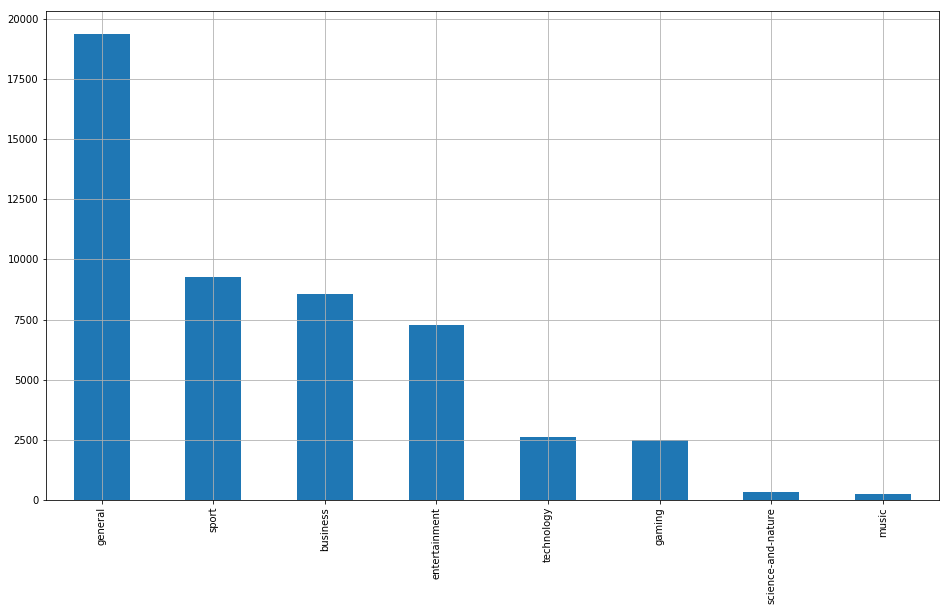

In [12]:
data['category'].value_counts().plot(kind='bar', grid=True, figsize=(16, 9))

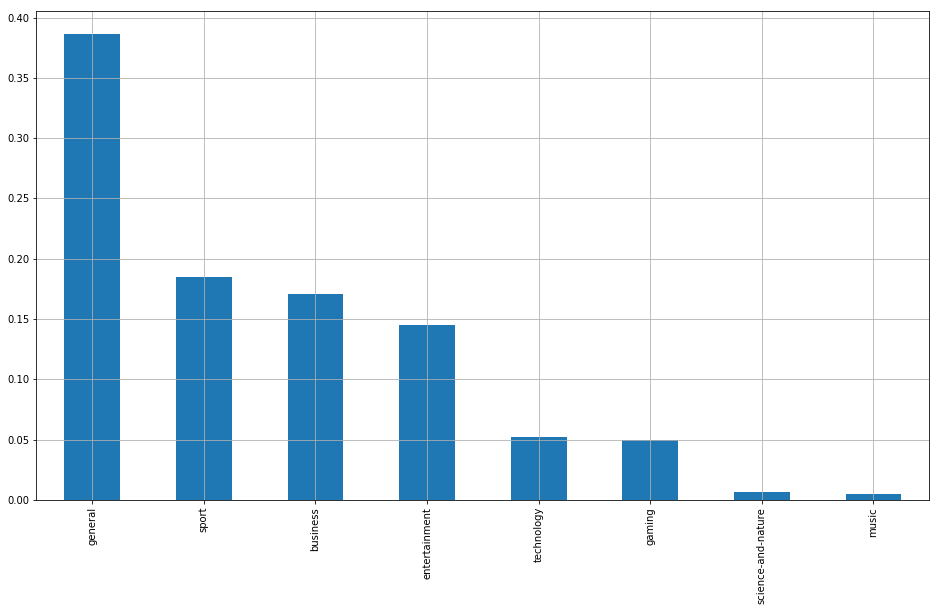

In [13]:
data.category.value_counts(normalize=True).plot(kind='bar', grid=True, figsize=(16, 9))

Many mixed topics are included in the "general" category.

This gives us a very superficial classificaion of the news. It doesn't tell us the underlying topics, nor the keywords and and the most relevant news per each category. All we have is a high level idea.

To get that sort of information, we'll have to process the descriptions of each article since these variables naturally carry more meanings.

Back to our text feature, let's focus on the news articles whose descriptions' length is higher than 140 characters (a tweet length). Shorter descriptions happen to introduce lots of noise.

**Remove duplicate** description columns

In [14]:
data = data.drop_duplicates('description')

In [15]:
data = data[~data['description'].isnull()]

print(data.shape)

(44773, 9)


Select descriptions of length between 140 and 300 characters.

In [16]:
data = data[(data.description.map(len) > 140) & (data.description.map(len) <= 300)]
data.reset_index(inplace=True, drop=True)

print(data.shape)

(13259, 9)


Let's now check the disctribution of the descriptions' lengths.

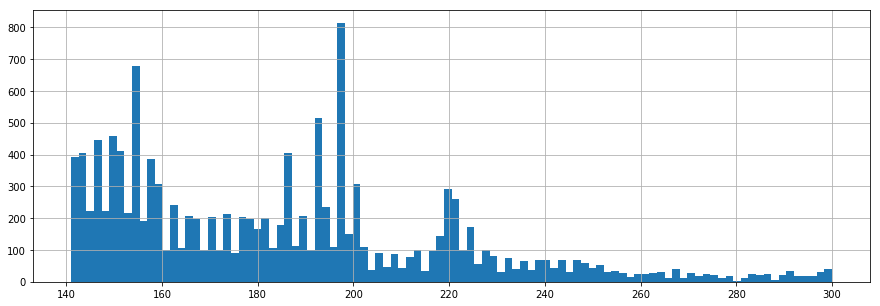

In [17]:
data.description.map(len).hist(figsize=(15, 5), bins=100)

Due to memory constraints on some packages used in this tutorial, we will limit the analysis to 10000 news.

In [18]:
data = data.sample(10000, random_state=42)
data.reset_index(inplace=True, drop=True)

data.head(2)

,author,description,publishedAt,source,title,url,urlToImage,category,scraping_date
0,Craig Torres,Demographic trends are already slowing immigra...,2017-03-23T04:01:00.004Z,bloomberg,No Need for a Wall: Latin Demographics to Shri...,https://www.bloomberg.com/politics/articles/20...,https://assets.bwbx.io/s3/javelin/public/javel...,business,2017-03-23 06:05:26.107702
1,"By Richard Spillett, Crime Correspondent For M...",Six jails are offering child abusers drugs to ...,2017-03-01T12:12:12Z,daily-mail,Jailed paedophiles could be 'chemically castra...,http://www.dailymail.co.uk/news/article-427050...,http://i.dailymail.co.uk/i/pix/2017/03/01/08/0...,entertainment,2017-03-01 13:20:26.079158


# 3)Text processing

### 3a) tokenization
- lowercase the text and clean it (separate function)
- break the descriptions into sentences and then break the sentences into tokens
- remove punctuation, stop words


I have used author's made

In [19]:
stop_words = []

f = open('stopwords.txt', 'r')
for l in f.readlines():
    stop_words.append(l.replace('\n', ''))
    
additional_stop_words = ['t', 'will']
stop_words += additional_stop_words

print(len(stop_words))

668


Tow additional function comes in.

They remove non ascii characters and standardize the text (can't -> cannot, i'm -> i am). This will make the tokenization process more efficient.

In [20]:
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

Integrate these two functions into a tokenizing function.

In [21]:
from functools import reduce
def tokenizer(text):
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop_words + list(punctuation)) , tokens))
    return tokens

A new column 'tokens' can be easily created using the map method applied to the 'description' column.

In [22]:
data['description'] = data['description'].map(lambda d: unicode(d))

In [23]:
data['description'][:3]

0    Demographic trends are already slowing immigra...
1    Six jails are offering child abusers drugs to ...
2    Washington Huskies wide receiver John Ross off...
Name: description, dtype: object

In [24]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
data['tokens'] = data['description'].progress_map(lambda d: tokenizer(d))

progress-bar: 100%|████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2124.38it/s]


The tokenizer has been applied to each description through all rows. Each resulting value is then put into the 'tokens' column that is created after the assignment. Let's check what the tokenization looks like for the first 5 descriptions:

In [25]:
for descripition, tokens in zip(data['description'].head(5), data['tokens'].head(5)):
    print('description:', descripition)
    print('tokens:', tokens)
    print()

description: Demographic trends are already slowing immigration to the U.S. from Latin America, making the current administration’s desire for a border wall look “anachronistic,” according to new research by University of California, San Diego, economists.
tokens: ['demographic', 'trends', 'slowing', 'immigration', 'latin', 'america', 'making', 'current', 'administration', 'desire', 'border', 'wall', 'anachronistic', 'university', 'california', 'san', 'diego', 'economists']

description: Six jails are offering child abusers drugs to reduce sexual interest and obsessive behaviour while they serve their sentences after it was trialled at HMP Whatton in Nottinghamshire.
tokens: ['jails', 'offering', 'child', 'abusers', 'drugs', 'reduce', 'sexual', 'interest', 'obsessive', 'behaviour', 'serve', 'sentences', 'trialled', 'hmp', 'whatton', 'nottinghamshire']

description: Washington Huskies wide receiver John Ross officially broke Chris Johnson's long-standing 40-yard-dash record Saturday   a

In [26]:
data.columns

Index(['author', 'description', 'publishedAt', 'source', 'title', 'url',
       'urlToImage', 'category', 'scraping_date', 'tokens'],
      dtype='object')

In [27]:
print(data['description'][15])
print(data['tokens'][15])

U.S.-backed Iraqi forces advancing in the Islamic State group's  stronghold in western Mosul fought off a counter-attack by the militants during bad weather in the early hours of Thursday, officers said.
['backed', 'iraqi', 'forces', 'advancing', 'islamic', 'state', 'group', 'stronghold', 'western', 'mosul', 'fought', 'counter', 'attack', 'militants', 'bad', 'weather', 'early', 'hours', 'thursday', 'officers']


### checking keyword by each category
Let's group the tokens by category, apply a word count and display the top 10 most frequent tokens.

In [28]:
# 1st check with uncleaned data
def keywords(category):
    tokens = data[data['category'] == category]['description']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(10)

In [29]:
for category in set(data['category']):
    print('category :', category)
    print('top 10 keywords:', keywords(category))
    print('---')

category : music
top 10 keywords: [(' ', 309), ('e', 171), ('o', 122), ('t', 119), ('a', 112), ('r', 100), ('n', 99), ('i', 93), ('s', 86), ('h', 66)]
---
category : entertainment
top 10 keywords: [(' ', 53441), ('e', 31134), ('a', 21964), ('t', 20414), ('o', 18748), ('n', 18657), ('i', 18636), ('r', 17348), ('s', 16602), ('h', 12291)]
---
category : business
top 10 keywords: [(' ', 40503), ('e', 24934), ('t', 18052), ('a', 17496), ('i', 16209), ('n', 15693), ('o', 15446), ('s', 14206), ('r', 14184), ('l', 8821)]
---
category : sport
top 10 keywords: [(' ', 36771), ('e', 21328), ('a', 15662), ('t', 14879), ('n', 12979), ('o', 12666), ('i', 12620), ('r', 11563), ('s', 11306), ('h', 8370)]
---
category : gaming
top 10 keywords: [(' ', 519), ('e', 277), ('a', 212), ('t', 203), ('o', 202), ('n', 167), ('r', 165), ('i', 156), ('s', 155), ('l', 114)]
---
category : technology
top 10 keywords: [(' ', 17836), ('e', 9959), ('t', 7320), ('a', 7068), ('o', 6774), ('i', 6120), ('n', 6001), ('s', 5

In [30]:
# check with cleaned token data
def keywords(category):
    tokens = data[data['category'] == category]['tokens']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(10)

In [31]:
for category in set(data['category']):
    print('category :', category)
    print('top 10 keywords:', keywords(category))
    print('---')

category : music
top 10 keywords: [('geordie', 3), ('shore', 3), ('facial', 2), ('best', 2), ('star', 2), ('reports', 2), ('bear', 2), ('charlotte', 2), ('crosby', 2), ('babe', 2)]
---
category : entertainment
top 10 keywords: [('year', 145), ('people', 127), ('time', 106), ('week', 98), ('pictured', 92), ('season', 88), ('night', 88), ('appeared', 85), ('series', 85), ('episode', 84)]
---
category : business
top 10 keywords: [('trump', 375), ('president', 278), ('donald', 214), ('house', 129), ('year', 104), ('people', 81), ('state', 69), ('administration', 68), ('white', 67), ('care', 66)]
---
category : sport
top 10 keywords: [('team', 140), ('year', 134), ('season', 130), ('nfl', 119), ('time', 93), ('league', 91), ('free', 89), ('win', 79), ('ian', 73), ('rapoport', 73)]
---
category : gaming
top 10 keywords: [('ign', 5), ('playing', 5), ('gaming', 3), ('hd', 3), ('well', 2), ('deals', 2), ('justice', 2), ('league', 2), ('feature', 2), ('breath', 2)]
---
category : technology
top 

**Lots of extra and useless words have been cleaned**

Few key points from given word data:
- the sport category deals with NFL i.e National Football League. we can also see some sport related terms such as "win", "time", "team" and players.
- tech articles refer to Google, Uber, and apple
- the business news seem to be highly linked to US politics and Donald Trump (this mainly originates from US press)

However, although we did preprocess the descriptions and remove the stop words before, we still end up with words that are very generic (e.g: today, year, people) that don't carry a specific meaning that may describe a topic.

As a first approach to prevent this, we will use tf-idf

## Tf-idf

tf-idf stands for term frequencey-inverse document frequency. It's a numerical statistic intended to reflect how important a word is to a document or a corpus (i.e a collection of documents).

To relate to this post, words correpond to tokens and documents correpond to descriptions. A corpus is therefore a collection of descriptions.

The tf-idf a of a term t in a document d is proportional to the number of times the word t appears in the document d but is also offset by the frequency of the term t in the collection of the documents of the corpus. This helps adjusting the fact that some words appear more frequently in general and don't especially carry a meaning.

tf-idf acts therefore as a weighting scheme to extract relevant words in a document.

Computing the tfidf matrix is done using the TfidfVectorizer method from scikit-learn. Let's see how to do this:

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2), stop_words='english')
vz = vectorizer.fit_transform(list(data['tokens'].map(lambda tokens: ' '.join(tokens))))

vz.shape

(10000, 7204)

In [33]:
# compare original data with vz
print(data.shape), print(vz.shape)

(10000, 10)
(10000, 7204)


(None, None)

vz is a tfidf matrix.

its number of rows is the total number of documents (descriptions)
its number of columns is the total number of unique terms (tokens) across the documents (descriptions)
x_dt = tfidf(t,d) where x_dt is the element at the index (d,t) in the matrix.

Let's create a **dictionary** mapping the tokens to their tfidf values

### Dictionary

In [34]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [35]:
tfidf.head()

,tfidf
aaron,7.645491
aaron rodgers,8.418681
abandon,8.013216
abandoned,8.264530
abandoning,8.418681


We can visualize the distribution of the tfidf scores through an histogram

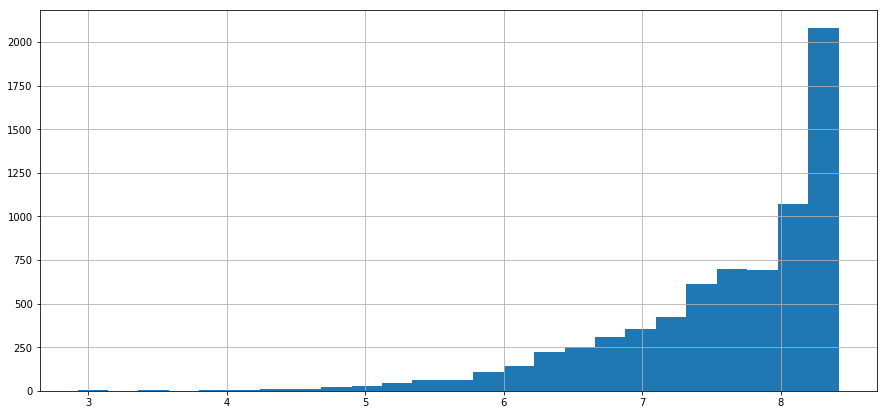

In [36]:
tfidf.tfidf.hist(bins=25, figsize=(15,7))

Let's display the **30 tokens that have the lowest tfidf scores**

In [37]:
from wordcloud import WordCloud

def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

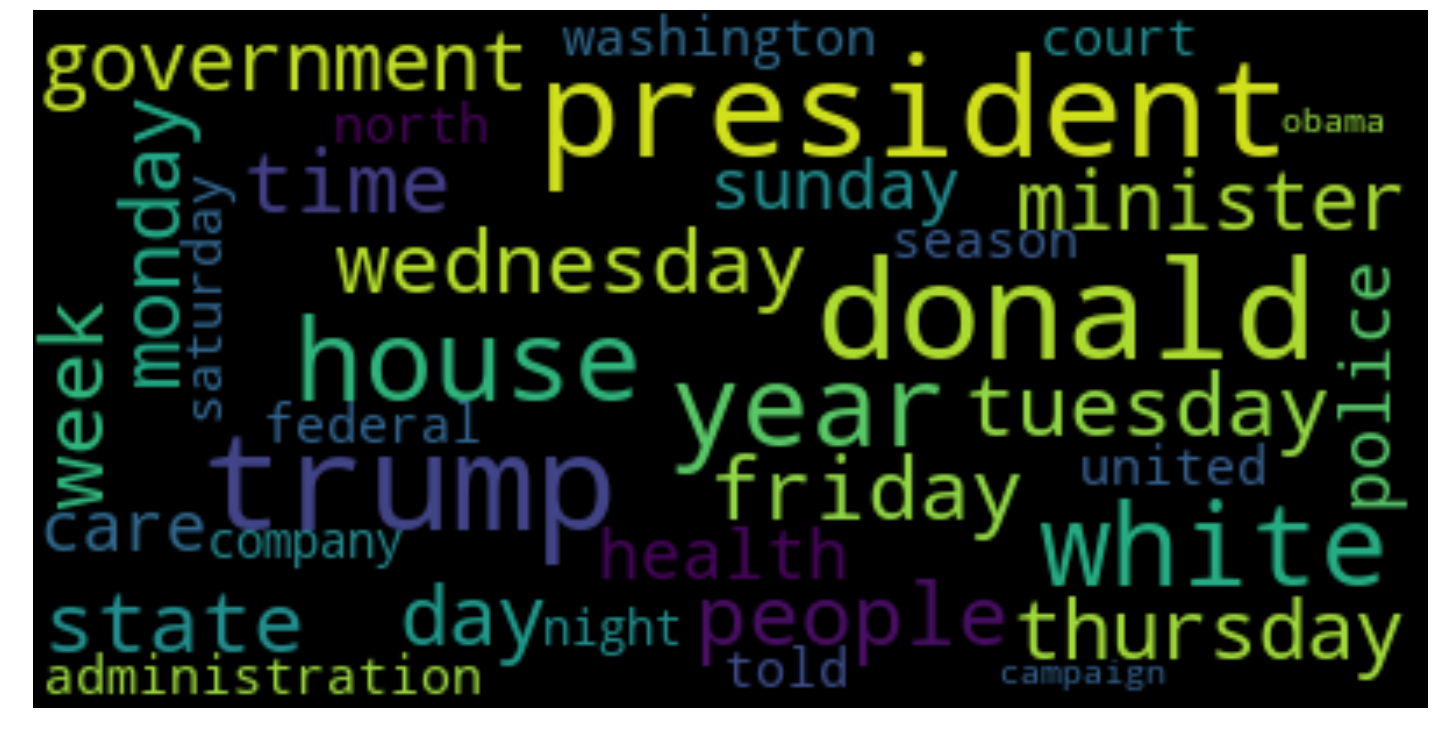

In [38]:
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=True).head(40))

Not surprisingly, we end up with a list of very generic words. These are very common across many descriptions. tfidf attributes a low score to them as a penalty for not being relevant. Words likes tuesday, friday, day, time, etc..

Now let's check out the **30 words** with the highest tfidf scores.

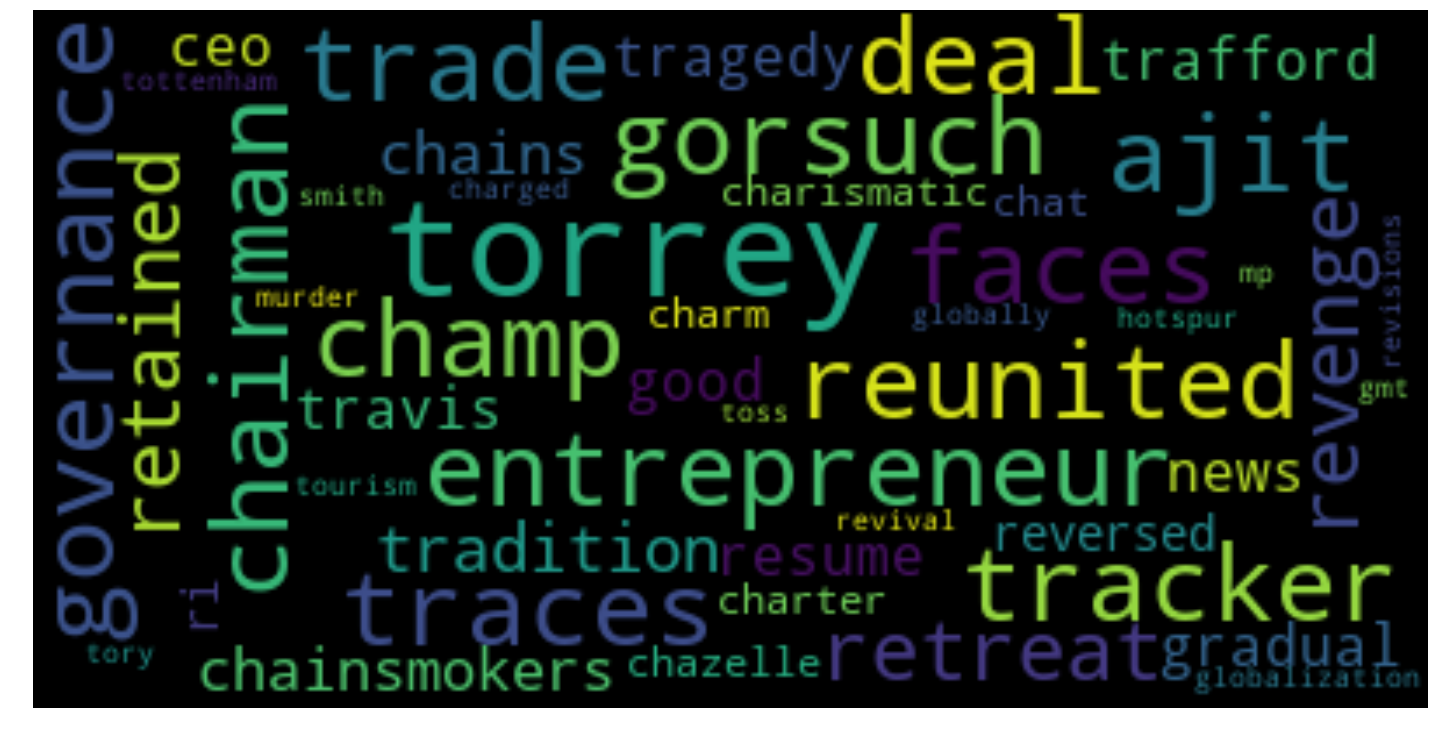

In [39]:
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=False).head(40))

We end up with less common words. These words naturally carry more meaning for the given description and may outline the underlying topic.

As you've noticed, the documents have more than 7000 features (see the vz shape). put differently, each document has more than 7000 dimensions.

If we want to plot them like we usually do with geometric objects, we need to reduce their dimension to 2 or 3 depending on whether we want to display on a 2D plane or on a 3D space. This is what we call dimensionality reduction.

### Dimensionality reduction

To perform this task, we'll be using a combination of two popular techniques: **Singular Value Decomposition (SVD)** to reduce the dimension to 50 and then **t-SNE** to reduce the dimension from 50 to 2. t-SNE is more suitable for dimensionality reduction to 2 or 3.

Let's start reducing the dimension of each vector to 50 by SVD.

In [40]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf = svd.fit_transform(vz)

svd_tfidf.shape

(10000, 50)

Now let's do better. From 50 to 2!

In [41]:
run = False
if run:
# run this (takes times)
    from sklearn.manifold import TSNE
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
    tsne_tfidf = tsne_model.fit_transform(svd_tfidf)
    print(tsne_tfidf.shape)
    tsne_tfidf_df = pd.DataFrame(tsne_tfidf)
    tsne_tfidf_df.columns = ['x', 'y']
    tsne_tfidf_df['category'] = data['category']
    tsne_tfidf_df['description'] = data['description']
    tsne_tfidf_df.to_csv('tsne_tfidf.csv', encoding='utf-8', index=False)
else:
# or import the dataset directly
    tsne_tfidf_df = pd.read_csv('tsne_tfidf.csv')

Each description is now modeled by a two dimensional vector.

Let's see what tsne_idf looks like on a 2D plane.

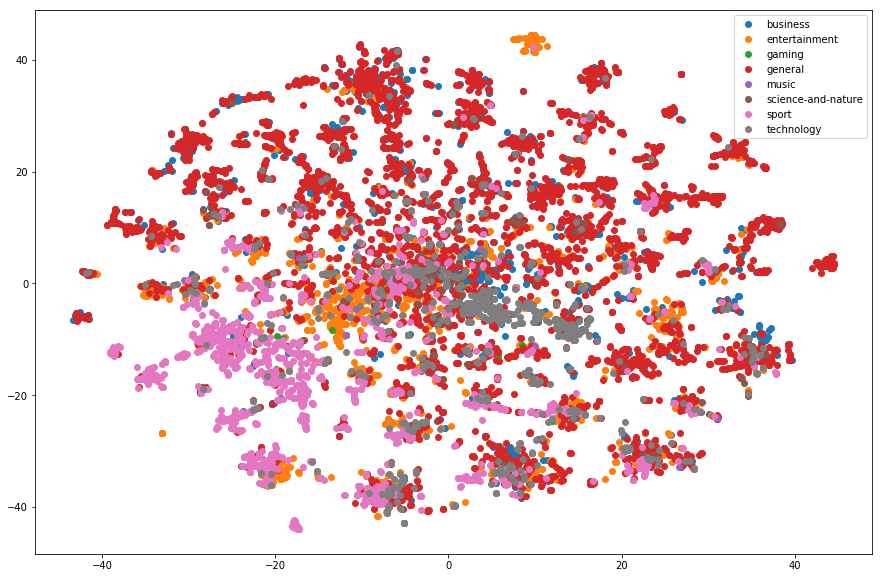

In [42]:
groups = tsne_tfidf_df.groupby('category')
fig, ax = plt.subplots(figsize=(15, 10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', label=name)
ax.legend()
plt.show()

We're having two float numbers per discription. This is not interpretable at first sight.

What we need to do is find a way to display these points on a plot and also attribute the corresponding description to each point.

matplotlib is a very good python visualization libaray. However, we cannot easily use it to display our data since we need interactivity on the objects. One other solution could be d3.js that provides huge capabilities in this field.

Right now I'm choosing to stick to python so I found a tradeoff : it's called Bokeh.

In [43]:
#Let's start by importing bokeh packages and initializing the plot figure.
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.io import save, output_file

In [47]:
#output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="tf-idf clustering of the news",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

palette = d3['Category10'][len(tsne_tfidf_df['category'].unique())]
color_map = bmo.CategoricalColorMapper(factors=tsne_tfidf_df['category'].map(str).unique(), palette=palette)

plot_tfidf.scatter(x='x', y='y', color={'field': 'category', 'transform': color_map},legend='category', source=tsne_tfidf_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "category":"@category"}

show(plot_tfidf)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [48]:
from bokeh.plotting_helpers import ColumnDataSource

plot_tfidf.scatter(x='x', y='y', source=ColumnDataSource(tfidf_df))
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "category":"@category"}
show(plot_tfidf)

ModuleNotFoundError: No module named 'bokeh.plotting_helpers'